In [1]:
!pip install mido
!pip install pretty_midi
!pip install music21

In [2]:
import mido as md
from mido import Message
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import variable
from sklearn.preprocessing import MinMaxScaler
import random as rnd
import pretty_midi
import collections
from torch.utils import data
import os
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import pickle
import random
import math
import statistics
import copy
import sys
import scipy
import music21 as m21

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
transpose_table = {"A-": 1, "A":0, "B-": -1, "B": -2, "C": -3, "C#": -4, "D-": -4, "D": -5, "E-": -6, "E": 5, "F": 4, "F#": 3, "G-": 3, "G": 2, "G#": 1}

In [5]:
def extractMessages(midi_file: str, features_to_drop = [], base_bpm = 240, normalize_time = False, normalize_scale=False):
    pm = pretty_midi.PrettyMIDI(midi_file)
    estimated_bpm = pm.estimate_tempo()
    bpm_ratio = estimated_bpm/base_bpm
    if(not normalize_time):
        bpm_ratio = 1
    notes = collections.defaultdict(list)
    for instrument in pm.instruments:
        if(not instrument.is_drum and instrument.program < 97): # filter out drum instruments
            # Sort the notes by start time inside the instrument
            sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
            prev_start = sorted_notes[0].start*bpm_ratio
            prev_pitch = 0

            for note in sorted_notes:
                if (note.pitch < 120):
                    start = note.start
                    end = note.end
                    notes['note'].append(note.pitch)
                    notes['start'].append(start*bpm_ratio)
                    notes['step'].append(start - prev_start) # step = midi event timing, delta time relative to previous event
                    notes['duration'].append((end - start)*bpm_ratio)
                    notes['end'].append(start*bpm_ratio + (end - start)*bpm_ratio)
                    notes['program'].append(instrument.program)
                    notes['local_diff'].append(note.pitch - prev_pitch)
                    notes['is_piano'].append(int(instrument.program >= 1 and instrument.program <=8 ))
                    notes['is_organ'].append(int(instrument.program >= 17 and instrument.program <=24 ))
                    notes['is_guitar'].append(int(instrument.program >= 25 and instrument.program <=32 ))
                    notes['is_bass'].append(int(instrument.program >= 33 and instrument.program <=40 ))
                    notes['is_strings'].append(int(instrument.program >= 41 and instrument.program <=48 ))
                    notes['is_ensemble'].append(int(instrument.program >= 49 and instrument.program <=56 ))
                    notes['is_brass'].append(int(instrument.program >= 57 and instrument.program <=64 ))
                    notes['is_reed'].append(int(instrument.program >= 65 and instrument.program <=72 ))
                    notes['is_pipe'].append(int(instrument.program >= 73 and instrument.program <=80 ))
                    notes['is_synth_lead'].append(int(instrument.program >= 81 and instrument.program <=88 ))
                    notes['is_synth_pad'].append(int(instrument.program >= 89 and instrument.program <=96 ))
                    prev_start = start
                    prev_pitch = note.pitch
            
    # sort all notes before resulting DF
    result = pd.DataFrame({name: np.array(value) for name, value in notes.items()})
    result = result.sort_values(by=['start'], ignore_index=True).reset_index(drop=True)

    # normalize scale - transpose to each scale A
    if(normalize_scale):
        score = m21.converter.parse(midi_file)
        key = score.analyze('key')
        print(str(key.tonic))
        print(transpose_table[str(key.tonic)])
        result["note"] = result["note"] + transpose_table[str(key.tonic)]

    # calculate diff
    diff = []
    for i in range(len(result["note"])-1 , 0, -1):
          diff.insert(0,result["note"][i] - result["note"][i-1])
    diff.insert(0,result["note"][0]) # first note diff is it's distance from 0.
    result["diff"] = diff

    # count previous observations for each note
    observed = np.zeros(128)
    obs_column = []
    for i in range(len(result["note"])):
        cur_note = result["note"][i]
        obs_column.append(observed[cur_note])
        observed[cur_note]+=1
    result["observed"] = obs_column

    # assign tokens
    token_column = list(range(len(result["note"])))
    result["token"] = token_column

    
    # show most common note (mode)
    number_list = list(observed)
    print(number_list.index(observed.max()))
    

    return result.drop(features_to_drop, axis = 1)

### open real data and set initial parameters for the model

In [6]:
midi_dir = '/content/drive/MyDrive/Data Science project/Data/byCluster5/cluster5/'
midi_files = os.listdir(midi_dir)

In [7]:
load_from_pickle = True # we save the processed data as pickle to save run time on future executions
columns = ["note","start","end","step","duration","program", "diff", "observed", "token", 'local_diff', 'is_piano', 'is_organ', 'is_guitar', 'is_bass', 'is_strings', 'is_ensemble', 'is_brass', 'is_reed', 'is_pipe', 'is_synth_lead', 'is_synth_pad'] # do not touch this line
features_to_drop = ["end","step","program","token", "observed"]
columns = [item for item in columns if item not in features_to_drop]
comp_length = 192
num_features = len(columns)
seed_size = 192
songs_processed = 0

if(not load_from_pickle):
    print("Reading from disk...")
    x = np.array([])
    y = np.array([])
    i = 0
    for song in midi_files:
        raw_data = extractMessages(midi_dir + song, features_to_drop=features_to_drop, base_bpm=210, normalize_time=True, normalize_scale = True)
        print(song)
        print(len(raw_data["note"]))
        if(len(raw_data["note"]) < comp_length):
            print("not enough notes in this song!")
        note_slice = raw_data[0:comp_length]
        note_slice.reset_index(drop=True, inplace=True)
        x = np.append(x, note_slice.to_numpy().reshape(1, comp_length, num_features))
        y = np.append(y, [1])
        print("---")
        
        i+=1
        if(i%25 == 0):
          print("Loaded: %d files" %i)

    x_real = x.reshape(len(midi_files), -1)
    y_real = y.reshape(len(midi_files), -1)
    pickle.dump(columns, open("/content/drive/MyDrive/Data Science project/Data/columns_cluster0_100bpm.pickle", "wb"))
    pickle.dump(x_real, open("/content/drive/MyDrive/Data Science project/Data/x_real_cluster0_100bpm.pickle", "wb"))
    pickle.dump(y_real, open("/content/drive/MyDrive/Data Science project/Data/y_real_cluster0_100bpm.pickle", "wb"))
    print("Data saved to pickle")

else:
    columns = pickle.load(open("/content/drive/MyDrive/Data Science project/Data/columns_cluster0_100bpm.pickle", "rb"))
    x_real = pickle.load(open("/content/drive/MyDrive/Data Science project/Data/x_real_cluster0_100bpm.pickle", "rb"))
    y_real = pickle.load(open("/content/drive/MyDrive/Data Science project/Data/y_real_cluster0_100bpm.pickle", "rb"))
    print("Loaded from Pickle with columns:")
    print(columns)

Loaded from Pickle with columns:
['note', 'start', 'duration', 'diff', 'local_diff', 'is_piano', 'is_organ', 'is_guitar', 'is_bass', 'is_strings', 'is_ensemble', 'is_brass', 'is_reed', 'is_pipe', 'is_synth_lead', 'is_synth_pad']


### Fit a scaler for the data and transform it to ease the weight balancing for the networks

In [8]:
scaler = MinMaxScaler()
x_real = scaler.fit_transform(x_real)
x_real = torch.from_numpy(x_real)
y_real = torch.from_numpy(y_real)

### Define and init discriminator and generator

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_size = comp_length * num_features
        self.layer_multiplier = 128

        self.bn1 = nn.BatchNorm1d(num_features)

        #convolution 1
        self.conv1_kernel_size = 32
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=num_features*2, kernel_size=self.conv1_kernel_size, padding="same", padding_mode="zeros")
        self.mp1 = nn.MaxPool1d(num_features)

        #fc1
        self.fc1_in_size = comp_length*num_features*2 
        self.fc1 = nn.Sequential(
            nn.Linear(self.fc1_in_size, self.fc1_in_size),
            nn.LeakyReLU(0.2),
            )
        
        #convolution 2
        self.conv2_kernel_size = 32
        self.conv2 = nn.Conv1d(in_channels=num_features*2, out_channels=num_features*4, kernel_size=self.conv2_kernel_size, padding="same", padding_mode="zeros")
        self.mp2 = nn.MaxPool1d(num_features)

        #fc2
        self.fc2_in_size = (comp_length)*num_features*4 
        self.fc2 = nn.Sequential(
            nn.Linear(self.fc2_in_size, self.fc2_in_size),
            nn.LeakyReLU(0.2)
            )
        
        #convolution 3
        self.conv3_kernel_size = 8
        self.conv3 = nn.Conv1d(in_channels=num_features*4, out_channels=num_features*num_features, kernel_size=self.conv3_kernel_size, padding="same", padding_mode="zeros")
        self.mp3 = nn.MaxPool1d(num_features)

        #fc3
        self.fc3_in_size = comp_length*num_features
        self.fc3 = nn.Sequential(
            nn.Linear(self.fc3_in_size, self.fc3_in_size),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.2),
            nn.Linear(self.fc3_in_size, 1),
            nn.Sigmoid()
            )
        
    def forward(self, x):
        x = x.reshape(-1, num_features, comp_length)
        x = self.conv1(x)
        x = x.reshape(-1, self.fc1_in_size)
        x = self.fc1(x)
        x = x.reshape(-1, num_features*2, comp_length)
        x = self.conv2(x)
        x = x.reshape(-1, self.fc2_in_size)
        x = self.fc2(x)
        x = x.reshape(-1, num_features*4, comp_length)
        x = self.mp3(self.conv3(x))
        x = x.reshape(-1, self.fc3_in_size)
        x = self.fc3(x)
        return x

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = seed_size
        self.layer_multiplier = 128

        #fc1 - transform the seed into an initial song shape
        self.fc1 = nn.Sequential(
            nn.Linear(self.input_size, 2*self.input_size, bias=False),
            nn.LeakyReLU(0.2),
            nn.Linear(2*self.input_size, 4*self.input_size, bias=False),
            nn.LeakyReLU(0.2),
            nn.Linear(4*self.input_size, 5*self.input_size, bias=False),
            nn.LeakyReLU(0.2),
            nn.Linear(5*self.input_size, 6*self.input_size, bias=False),
            nn.LeakyReLU(0.2),
            nn.Linear(6*self.input_size, 7*self.input_size, bias=False),
            nn.LeakyReLU(0.2),
            nn.Linear(7*self.input_size, 8*self.input_size, bias=False),
            nn.LeakyReLU(0.2),
            nn.Linear(8*self.input_size, comp_length*num_features, bias=False)
        )

        self.bn1 = nn.BatchNorm1d(num_features)

        #convolution 1
        self.conv1_kernel_size = 32
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=num_features*2, kernel_size=self.conv1_kernel_size, padding="same", padding_mode="zeros")

        #fc 2 
        self.fc2_in_size = comp_length*num_features 
        self.fc2 = nn.Sequential(
        nn.Linear(self.fc2_in_size, 8*self.input_size, bias=False),
        nn.LeakyReLU(0.2),
        nn.Linear(8*self.input_size, self.fc2_in_size, bias=False),
        nn.LeakyReLU(0.2)
        )

        #convolution 2
        self.conv2_comp_length = comp_length
        self.conv2_kernel_size = 24
        self.conv2 = nn.Conv1d(in_channels=num_features*2, out_channels=num_features*3, kernel_size=self.conv2_kernel_size, padding="same", padding_mode="zeros")

        
        #fc 3
        self.fc3_in_size = (self.conv2_comp_length)*num_features*3 # each convolution loses (kernel_size) features (because of the layer edges)
        self.fc3 = nn.Sequential(
        nn.LeakyReLU(0.2)
        )
        

        #convolution 3
        self.conv3_comp_length = self.conv2_comp_length
        self.conv3_kernel_size = 20
        self.conv3 = nn.Conv1d(in_channels=num_features*3, out_channels=num_features*4, kernel_size=self.conv3_kernel_size, padding="same", padding_mode="zeros")

        #fc 4
        self.fc4_in_size = self.conv3_comp_length*num_features*4
        self.fc4 = nn.Sequential(
        nn.LeakyReLU(0.2)
        )
        

        #convolution 4
        self.conv4_comp_length = self.conv3_comp_length
        self.conv4_kernel_size = 8
        self.conv4 = nn.Conv1d(in_channels=num_features*4, out_channels=num_features*num_features, kernel_size=self.conv4_kernel_size, padding="same", padding_mode="zeros")
        self.mp4 = nn.MaxPool1d(num_features)

        #fc 5
        self.fc5_in_size = comp_length * num_features
        self.fc5 = nn.Sequential(
        nn.LeakyReLU(0.2),
        nn.Linear(self.fc5_in_size , comp_length * num_features, bias=False),
        )

    def forward(self, x):
        x = self.fc1(x)
        x = x.reshape(-1, num_features, comp_length)
        x = self.bn1(x)
        x = self.conv1(x)
        x = x.reshape(-1, self.fc2_in_size)
        x = self.fc2(x)
        x = x.reshape(-1, num_features*2, self.conv2_comp_length)
        x = self.conv2(x)
        x = x.reshape(-1, self.fc3_in_size)
        x = self.fc3(x)
        x = x.reshape(-1, num_features*3, self.conv3_comp_length)
        x = self.conv3(x)
        x = x.reshape(-1, self.fc4_in_size)
        x = self.fc4(x)
        x = x.reshape(-1, num_features*4, self.conv4_comp_length)
        x = self.mp4(self.conv4(x))
        x = x.reshape(-1, self.fc5_in_size)
        x = self.fc5(x)
        return x

### Define train routine

In [11]:
discriminator = Discriminator()
generator = Generator()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: %s" %device)
discriminator = discriminator.to(device)
generator = generator.to(device)
x_real, y_real = x_real.to(device), y_real.to(device)

generator

Using device: cuda


Generator(
  (fc1): Sequential(
    (0): Linear(in_features=192, out_features=384, bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=384, out_features=768, bias=False)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=768, out_features=960, bias=False)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=960, out_features=1152, bias=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=1152, out_features=1344, bias=False)
    (9): LeakyReLU(negative_slope=0.2)
    (10): Linear(in_features=1344, out_features=1536, bias=False)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Linear(in_features=1536, out_features=3072, bias=False)
  )
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1d(16, 32, kernel_size=(32,), stride=(1,), padding=same)
  (fc2): Sequential(
    (0): Linear(in_features=3072, out_features=1536, bias=False)
    (1): LeakyReLU(negative_slop

In [12]:
class MyDataset(data.Dataset):
    def __init__(self,X,Y):
        self.X = X
        self.Y=Y
        
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self,index):
        X = self.X[index].float().reshape(-1)
        Y = self.Y[index].float();
        return X,Y
    
batch_size = 16
train_dataset = MyDataset(x_real,y_real)
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

In [13]:
# train parameters:
lr_discriminator = 0.0001
lr_generator = 0.0001
num_epochs = 35
save_model_back = 1
num_epochs_random_eval = 0
loss_function = nn.BCELoss()
loss_randomness = nn.MSELoss()

# noise parameters:
mu, sigma = 0, 0.0005 # mean and standard deviation for the noise

# optimizers
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr_discriminator)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr_generator)

x_inp = x_real
seed = torch.randn(1, seed_size).to(device)

print(pd.DataFrame(generator(seed).detach().cpu().numpy().reshape(-1, num_features), columns = columns))
print(discriminator(generator(seed)))

         note     start  duration      diff  local_diff  is_piano  is_organ  \
0   -0.012469  0.015119 -0.002841 -0.006260    0.031681  0.027345  0.010530   
1    0.026207 -0.010159 -0.009116 -0.008674   -0.027968  0.022861  0.002011   
2   -0.016529 -0.010211  0.024139 -0.000860    0.001565 -0.001807  0.000053   
3    0.008349  0.006235  0.002887 -0.003523   -0.018075  0.022236  0.000486   
4   -0.018615  0.005913 -0.014341 -0.006262    0.034783  0.002184  0.018915   
..        ...       ...       ...       ...         ...       ...       ...   
187 -0.018873 -0.015537 -0.006321 -0.024079    0.018998  0.027196 -0.019464   
188 -0.004206  0.017321 -0.006667 -0.017912   -0.005757  0.011729 -0.010157   
189 -0.003289  0.001982  0.003893  0.013248   -0.015233  0.002264 -0.034525   
190 -0.012163 -0.004068  0.001449  0.012109   -0.015527  0.020806 -0.009559   
191 -0.006055 -0.000749  0.003851 -0.012006   -0.001344  0.014482  0.017224   

     is_guitar   is_bass  is_strings  is_ensemble  

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:299: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  self.padding, self.dilation, self.groups)


In [14]:
torch.set_printoptions(threshold=10_000)

In [15]:
def runsTest(l_in, l_median): 

    l = l_in[::num_features] # extracts only notes

    runs, n1, n2 = 0, 0, 0

    # Checking for start of new run
    for i in range(len(l)):
        # no. of runs (transformations from PtoN or NtoP)
        if (l[i] >= l_median and l[i-1] < l_median) or \
                (l[i] < l_median and l[i-1] >= l_median):
            runs += 1  
        
        # no. of positive values
        if(l[i]) >= l_median:
            n1 += 1   

        # no. of negative values
        else:
            n2 += 1   

    runs_exp = ((2*n1*n2)/(n1+n2))+1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/ \
                       (((n1+n2)**2)*(n1+n2-1)))
  
    if(stan_dev == 0):
        stan_dev = 0.000001
    z = (runs-runs_exp)/stan_dev

    result = z
  
    return result

In [16]:
def bartels_test(r_in):
    r = r_in[::num_features] # extract notes
    sum1 = 0
    for i in range(len(r)-1):
        sum1 += (r[i] - r[i+1])**2
    r_mean = np.array(r).mean()
    sum2 = 0
    for i in range(len(r)):
        sum2 += (r[i] - r_mean)**2
    result = sum1/sum2

    r = r_in[1::num_features] # extract start times
    r.sort() # sort by start time to reflect differences of each two consecutive events
    sum1 = 0
    for i in range(len(r)-1):
        sum1 += (r[i] - r[i+1])**2
    r_mean = np.array(r).mean()
    sum2 = 0
    for i in range(len(r)):
        sum2 += (r[i] - r_mean)**2
    result = result + sum1/sum2
    
    return result/2

In [17]:
print_every = 1
d_loss, g_loss, r_loss, z_ratio, z_real, z_generated, b_ratio, b_real, b_generated = ([],[],[],[],[],[],[],[],[])
GAN_at_epoch = {}
GAN_at_minZ = (None, None, sys.float_info.max, 0) # (generator, discriminator, abs(1-z_ratio), epoch)
GAN_at_minBart = (None, None, sys.float_info.max, 0) # (generator, discriminator, abs(1-z_ratio), epoch)
GAN_at_lastConvergence = (None, None, sys.float_info.max, 0) # (generator, discriminator, abs(1-z_ratio), epoch)
for epoch in range(num_epochs):
    loss_sum_d, loss_sum_g, loss_sum_r, num_batches = 0, 0, 0, 0
    z_batch_real, z_batch_generated = 0,0
    b_batch_real, b_batch_generated = 0,0
    for real_samples, real_labels in train_loader:
        num_batches+=1

        # seed generation
        latent_space_samples = torch.randn((len(real_samples), seed_size)).to(device=device)
        # generator: convert seed to "fake" data
        generated_samples = generator(latent_space_samples)
        # generated midi files are "fake" - all should be labled 0
        generated_samples_labels = torch.zeros((len(real_samples), 1)).to(device=device)
        
        # add noise to the real data to prevent weight memory on the discriminator
        # normal distribution helps maintaining the overall structure of the data
        noise = np.random.normal(mu, sigma, size=real_samples.shape) 
        noise_tensor = torch.from_numpy(noise).float().to(device)
        distorted_real_samples = real_samples + noise_tensor

        # to train the discriminator we add the real samples to the generated ones
        all_samples = torch.cat((distorted_real_samples, generated_samples))
        all_samples_labels = torch.cat((real_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples) # discriminator forward
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((len(real_samples), seed_size)).to(device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples) # generator forward
        output_discriminator_generated = discriminator(generated_samples) # discriminator gives feedback
        loss_generator = loss_function(output_discriminator_generated, real_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Calculate Z-statistic and Bartel's test for both real data and generated data
        z_real_mean_current, z_generated_mean_current = 0,0
        b_real_mean_current, b_generated_mean_current = 0,0
        real_samples_cpu = real_samples.detach().cpu()
        for i in range(len(real_samples)):
            z_real_mean_current+= runsTest(real_samples_cpu[i].numpy(), real_samples_cpu[i].median().numpy())
            b_real_mean_current+= bartels_test(real_samples_cpu[i].numpy())

        generated_samples_cpu = generated_samples.detach().cpu()
        for i in range(len(generated_samples)):
            z_generated_mean_current+= runsTest(generated_samples_cpu[i].numpy(), generated_samples_cpu[i].median().numpy())
            b_generated_mean_current+= bartels_test(generated_samples_cpu[i].numpy())

        # Get avarages for Z-statistic and Bartel's test 
        z_real_mean_current, z_generated_mean_current = z_real_mean_current/len(real_samples), z_generated_mean_current/len(output_discriminator_generated)
        z_batch_real+=z_real_mean_current
        z_batch_generated+=z_generated_mean_current

        b_real_mean_current, b_generated_mean_current = b_real_mean_current/len(real_samples), b_generated_mean_current/len(output_discriminator_generated)
        b_batch_real+=b_real_mean_current
        b_batch_generated+=b_generated_mean_current
        
        # Sum discriminator/generator/randomness loss
        loss_sum_d+= loss_discriminator.detach().cpu().numpy()
        loss_sum_g+= loss_generator.detach().cpu().numpy()

    loss_sum_d/=num_batches
    loss_sum_g/=num_batches
    d_loss.append(loss_sum_d)
    g_loss.append(loss_sum_g)

    z_batch_real/= num_batches
    z_batch_generated/= num_batches
    z_real.append(z_batch_real)
    z_generated.append(z_batch_generated)
    z_ratio.append(z_batch_generated/z_batch_real)

    b_batch_real/= num_batches
    b_batch_generated/= num_batches
    b_real.append(b_batch_real)
    b_generated.append(b_batch_generated)
    b_ratio.append(b_batch_generated/b_batch_real)


    # save minimum z_statistic ratio
    if(abs(1-z_batch_generated/z_batch_real) - epoch*0.0001 < GAN_at_minZ[2]): # prefer later epochs than small differences
          GAN_at_minZ = (copy.deepcopy(generator).to("cpu"), copy.deepcopy(discriminator).to("cpu"), abs(1-z_batch_generated/z_batch_real), epoch)
    # save minimum barlet test ratio
    if(abs(1-b_batch_generated/b_batch_real) - epoch*0.0001 < GAN_at_minBart[2]):
          GAN_at_minBart = (copy.deepcopy(generator).to("cpu"), copy.deepcopy(discriminator).to("cpu"), abs(1-b_batch_generated/b_batch_real), epoch)
    if(loss_sum_d < 0.9 and loss_sum_g < 0.9 and abs(1-z_batch_generated/z_batch_real) < 0.2):
          GAN_at_lastConvergence = (copy.deepcopy(generator).to("cpu"), copy.deepcopy(discriminator).to("cpu"), loss_sum_g, epoch)
    # Show loss
    if epoch%print_every == 0 or epoch == num_epochs-1:
        print(f"Epoch: {epoch} Loss Discriminator: {loss_sum_d}")
        print(f"Epoch: {epoch} Loss Generator: {loss_sum_g}")
        print(f"Epoch: {epoch} Z: %f B: %f" %(abs(1-z_batch_generated/z_batch_real), abs(1-b_batch_generated/b_batch_real)))
        print("-----")

Epoch: 0 Loss Discriminator: 0.481160972150974
Epoch: 0 Loss Generator: 2.000471747945994
Epoch: 0 Z: 1.000000 B: 0.166812
-----
Epoch: 1 Loss Discriminator: 0.4568557804450393
Epoch: 1 Loss Generator: 2.9704559929668903
Epoch: 1 Z: 0.800779 B: 0.009959
-----
Epoch: 2 Loss Discriminator: 0.06465620778863013
Epoch: 2 Loss Generator: 5.044960305094719
Epoch: 2 Z: 0.999999 B: 0.053833
-----
Epoch: 3 Loss Discriminator: 1.5626980163142434
Epoch: 3 Loss Generator: 25.7379699498415
Epoch: 3 Z: 0.755858 B: 0.051046
-----
Epoch: 4 Loss Discriminator: 0.2201732463145163
Epoch: 4 Loss Generator: 40.9943438321352
Epoch: 4 Z: 0.914898 B: 0.059486
-----
Epoch: 5 Loss Discriminator: 0.4140230529010296
Epoch: 5 Loss Generator: 1.8015014603734016
Epoch: 5 Z: 0.037109 B: 0.091708
-----
Epoch: 6 Loss Discriminator: 0.8011764893308282
Epoch: 6 Loss Generator: 4.45399072393775
Epoch: 6 Z: 0.000000 B: 0.148670
-----
Epoch: 7 Loss Discriminator: 0.6187389139086008
Epoch: 7 Loss Generator: 2.784317009150982


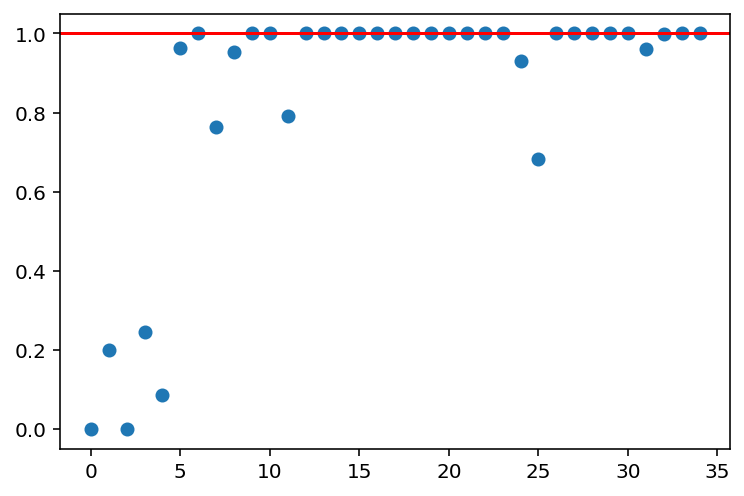

In [18]:
plt.scatter(range(len(z_ratio)), abs(np.array(z_ratio)))
plt.axhline(y = 1, color = 'r', linestyle = '-')

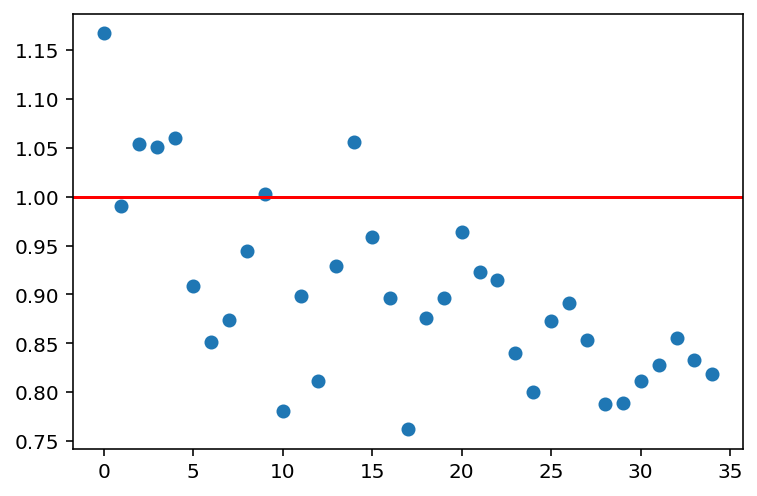

In [19]:
plt.scatter(range(len(b_ratio)), abs(np.array(b_ratio)))
plt.axhline(y = 1, color = 'r', linestyle = '-')

### Result analysis

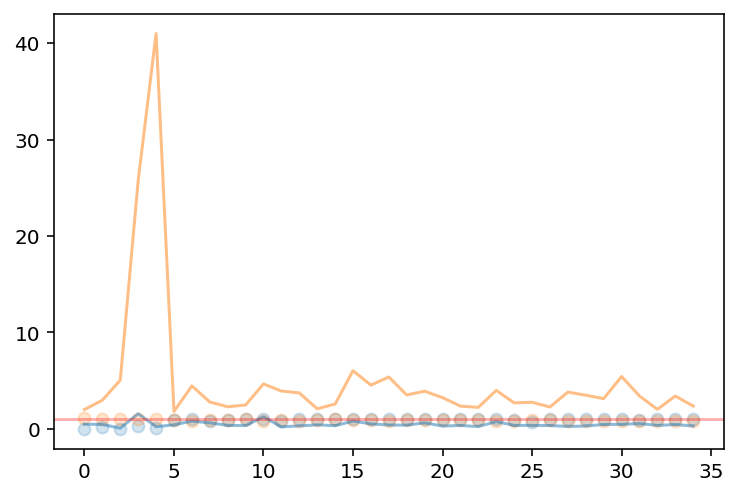

In [20]:
plt.plot(range(len(d_loss)), d_loss, alpha = 0.5);
plt.plot(range(len(g_loss)), g_loss, alpha = 0.5);
plt.scatter(range(len(z_ratio)), abs(np.array(z_ratio)), alpha = 0.2)
plt.scatter(range(len(b_ratio)), abs(np.array(b_ratio)), alpha = 0.2)
plt.axhline(y = 1, color = 'r', linestyle = '-', alpha = 0.3);

In [21]:
selected_method = GAN_at_minZ
z_dist_from_one = np.array([])
for i, val in enumerate(z_ratio):
    z_dist_from_one = np.append(z_dist_from_one, abs(val-1))
    if(i > num_epochs - save_model_back):
        print("Value: %f, Index: %d" %(abs(val-1),i))

In [22]:
selected_epoch_state = selected_method[3]
generator,discriminator = (selected_method[0], selected_method[1])
generator.to(device)
discriminator.to(device)

Discriminator(
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1d(16, 32, kernel_size=(32,), stride=(1,), padding=same)
  (mp1): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
  (fc1): Sequential(
    (0): Linear(in_features=6144, out_features=6144, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Conv1d(32, 64, kernel_size=(32,), stride=(1,), padding=same)
  (mp2): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
  (fc2): Sequential(
    (0): Linear(in_features=12288, out_features=12288, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Conv1d(64, 256, kernel_size=(8,), stride=(1,), padding=same)
  (mp3): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
  (fc3): Sequential(
    (0): Linear(in_features=3072, out_features=3072, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): LeakyReLU(negative_slope=0.2)
 

selected epoch: 34
selected epoch distance: 0.000000


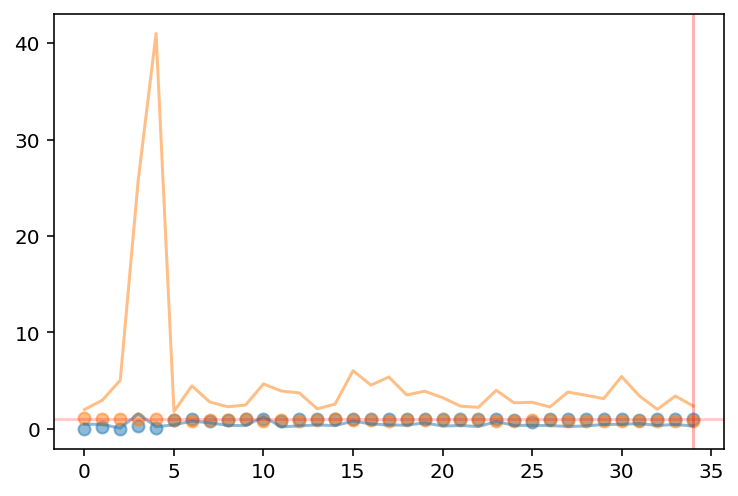

In [23]:
plt.plot(range(len(d_loss)), d_loss, alpha = 0.5);
plt.plot(range(len(g_loss)), g_loss, alpha = 0.5);
plt.scatter(range(len(z_ratio)), abs(np.array(z_ratio)), alpha = 0.5)
plt.scatter(range(len(b_ratio)), abs(np.array(b_ratio)), alpha = 0.5)
plt.axhline(y = 1, color = 'r', linestyle = '-', alpha = 0.2);
plt.axvline(x = selected_epoch_state, color = 'r', linestyle = '-', alpha = 0.3);
print("selected epoch: %d" %selected_epoch_state)
print("selected epoch distance: %f" %selected_method[2])

### Generate new file

Discriminator real data mean: 0.928


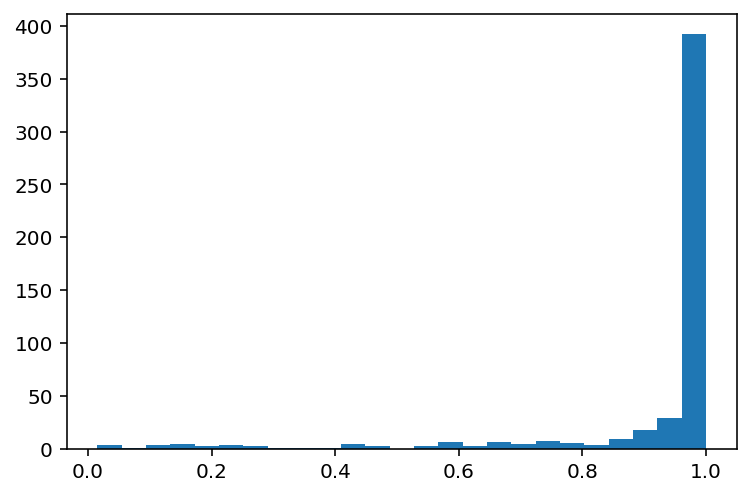

In [24]:
real_data_outputs = np.array([])
for real_samples, real_labels in train_loader:
    for real_song in real_samples:
        real_data_outputs = np.append(real_data_outputs, discriminator(real_song).detach().cpu().numpy())
print("Discriminator real data mean: %1.3f" %(real_data_outputs.mean()))
plt.hist(real_data_outputs, bins = 25);

In [25]:
generator_out = generator(seed).detach().cpu().numpy()
generator_out = scaler.inverse_transform(generator_out)
print(pd.DataFrame(generator_out.reshape(-1, num_features), columns = columns))
print(num_features)

          note      start  duration       diff  local_diff  is_piano  \
0    71.850212   1.694114 -0.136845  97.286919    0.070644  0.271920   
1    76.639374   2.054066  2.815304  54.974606    0.053901  0.232187   
2    75.835167   8.845159  2.072769  48.039150    0.144858  0.297754   
3    74.866447   3.631484 -1.282782  43.852203    0.158712  0.178205   
4    61.902515   1.550553 -0.295941  28.614737    0.079609  0.196354   
..         ...        ...       ...        ...         ...       ...   
187  75.462387  22.682314  0.828115   2.320135    0.110845  0.237911   
188  69.769028  20.676699  0.839759  13.448409    0.026747  0.074887   
189  64.942673  27.824127  0.581472  12.418854    0.072410  0.095653   
190  71.444420  33.028778  0.938841  -0.892848    0.177538  0.162297   
191  77.624855  26.436115  0.707160  16.034714    0.060296  0.162748   

     is_organ  is_guitar   is_bass  is_strings  is_ensemble  is_brass  \
0    0.015868   0.300145  0.041150    0.152214     0.161785  0

### Use the model to generate a MIDI file

In [26]:
def createFile(name, bpm, notes, instrument = 0):
    mid = md.MidiFile()
    track = md.MidiTrack()
    mid.tracks.append(track)
    
    mytempo = md.bpm2tempo(bpm)
    track.append(md.MetaMessage('set_tempo', tempo=mytempo, time=0))
    track.append(md.Message('program_change', program=instrument, time=0))
    for i in range(len(notes) - 1):
        track.append(md.Message('note_on', note=notes[i], velocity=64, time=30))
        if(i > 0):
            track.append(md.Message('note_off', note=notes[i - 1], velocity=127, time=120))

    track.append(md.Message('note_off', note=notes[i], velocity=64, time=30))
    
    mid.save(name)

In [27]:
def diff2notes(diffs):
    notes = [diffs[0]] # the first diff is always the base note
    for i in range(1, len(diffs) -1, 1):
        notes.append(notes[i-1] + diffs[i])
    return notes

In [76]:
max_generated = [0] # dummy midi file, will be replaced by the best scored file.
max_score = -1
avg_score = 0
num_tries = 3 # take the best out of 3
for i in range(num_tries):
    generated = generator(torch.randn((1, seed_size)).to(device))
    score = discriminator(generated).data
    avg_score+= score
    if score > max_score:
        max_generated = generated
        max_score = score
print("best score: %f" %max_score)
print("avg score: %f" %(avg_score/num_tries))

# we have our new data, we can prepare to write it as midi file
generated = generated.detach().cpu().numpy()
generated = scaler.inverse_transform(generated)
gan_result = pd.DataFrame(generated.reshape(-1, num_features), columns = columns)
if("diff" in columns):
    result_diffs = []
    for note in gan_result["diff"]:
        result_diffs.append(round(note))
    notes_from_diff = diff2notes(result_diffs)
    print(notes_from_diff)

if("note" in columns):
    result_notes = []
    for note in gan_result["note"]:
        result_notes.append(round(note))

gan_result

best score: 0.193181
avg score: 0.177594
[88, 136, 177, 215, 239, 270, 290, 309, 325, 340, 350, 368, 360, 380, 389, 404, 417, 419, 433, 453, 462, 469, 484, 493, 514, 537, 544, 556, 565, 582, 601, 613, 626, 633, 644, 664, 671, 687, 696, 703, 717, 729, 741, 753, 758, 766, 780, 796, 813, 825, 839, 846, 861, 872, 885, 897, 912, 916, 925, 926, 932, 947, 957, 964, 979, 991, 1003, 1022, 1031, 1048, 1065, 1077, 1080, 1088, 1101, 1116, 1123, 1129, 1134, 1151, 1170, 1182, 1186, 1191, 1199, 1199, 1206, 1212, 1219, 1224, 1225, 1234, 1244, 1251, 1266, 1275, 1290, 1303, 1316, 1333, 1336, 1348, 1354, 1364, 1371, 1380, 1395, 1412, 1421, 1429, 1436, 1439, 1447, 1456, 1477, 1490, 1495, 1509, 1526, 1538, 1550, 1556, 1573, 1584, 1587, 1593, 1598, 1600, 1609, 1613, 1629, 1629, 1641, 1657, 1668, 1674, 1679, 1699, 1710, 1725, 1731, 1750, 1757, 1770, 1779, 1784, 1789, 1801, 1805, 1814, 1820, 1834, 1844, 1848, 1858, 1860, 1871, 1886, 1913, 1929, 1942, 1959, 1973, 1984, 2003, 2016, 2034, 2038, 2043, 2056, 2069,

,note,start,duration,diff,local_diff,is_piano,is_organ,is_guitar,is_bass,is_strings,is_ensemble,is_brass,is_reed,is_pipe,is_synth_lead,is_synth_pad
0,67.933556,1.522238,-0.142882,87.605789,0.067351,0.254511,0.015850,0.277370,0.041202,0.141307,0.154762,0.023491,0.068624,-0.004540,0.013457,68.146774
1,72.068787,1.941970,2.573920,48.370358,0.051156,0.212655,0.043395,0.202042,0.100279,0.081828,0.023777,-0.018075,0.010918,0.077031,0.076571,11.039638
2,71.456718,8.027377,1.923625,41.329411,0.133170,0.276330,0.002084,0.103318,0.142051,0.167234,0.116163,0.029831,0.022688,0.007308,0.098176,17.445820
3,70.313210,3.256649,-1.496347,38.318916,0.149814,0.162822,0.022824,0.152231,0.062394,0.039780,0.121291,-0.023803,0.042331,-0.027368,0.086809,9.948693
4,59.128033,1.421284,-0.449774,23.750572,0.073125,0.183424,-0.062736,0.144096,0.117582,0.198141,0.044423,-0.019528,0.057622,0.138106,0.075476,16.360416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,70.897232,21.740976,0.787686,-0.007436,0.099284,0.222680,0.045702,0.311983,0.004545,0.024221,0.119910,-0.005376,0.099161,-0.014435,0.013533,17.785938
188,66.183960,19.491243,0.798326,10.611851,0.025386,0.070316,0.057481,0.213429,-0.009834,0.056623,0.114531,0.041357,0.090094,0.052636,0.008511,13.160013
189,61.638699,26.284065,0.571072,9.083656,0.068981,0.088232,-0.044338,0.361036,0.029478,0.123917,0.078730,0.007080,0.077537,-0.021743,-0.008487,13.454233
190,67.509735,30.962818,0.888313,-2.636603,0.167140,0.150092,0.007931,0.275467,0.059782,0.006734,0.121012,0.020175,0.112918,0.060102,-0.032694,12.213752


In [77]:
try_trace_diff = False
if("diff" in columns and try_trace_diff):
    result_notes_filtered = []
    for note in notes_from_diff:
      if note > 126 or note < 1:
        print("Warning: Integrity issue: %d" %note)
      else:
        result_notes_filtered.append(note)

    if len(result_notes_filtered) > 1:
      createFile("/content/drive/MyDrive/GAN out/GAN output diffs.mid", 100, result_notes_filtered)
      plt.scatter(range(len(result_notes_filtered)), result_notes_filtered)

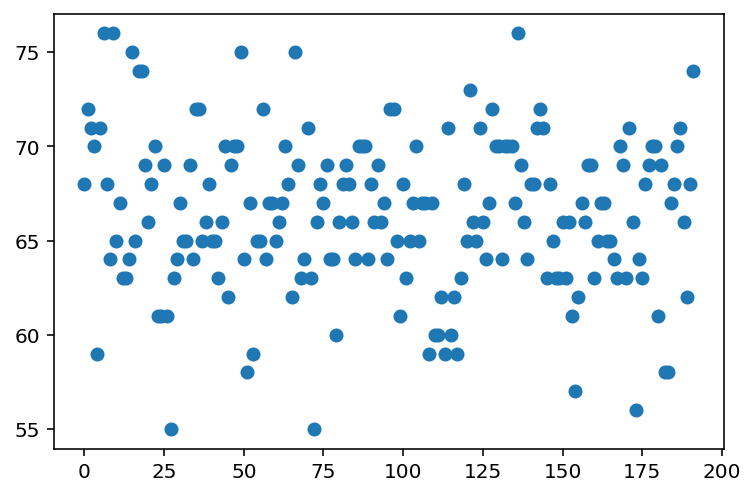

In [78]:
if("note" in columns):
    result_notes_filtered = []
    for note in result_notes:
      if note > 126 or note < 1:
        print("Warning: Integrity issue: %d" %note)
      else:
        result_notes_filtered.append(note)

    if len(result_notes_filtered) > 1:
        createFile("/content/drive/MyDrive/GAN out/GAN output notes.mid", 100, result_notes_filtered)
        plt.scatter(range(len(result_notes_filtered)), result_notes_filtered)

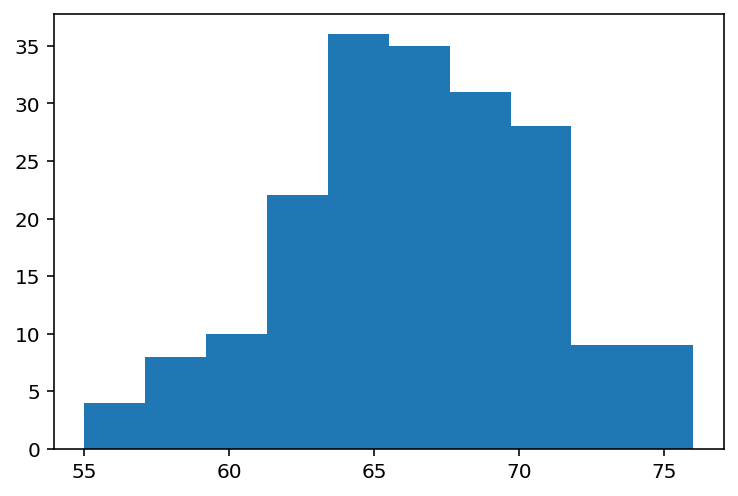

In [79]:
plt.hist(result_notes_filtered);

In [80]:
if "start" in columns:
    gan_result_sorted_by_start = gan_result.sort_values(by=['start'], ignore_index=True).reset_index(drop=True)
    result_notes = gan_result_sorted_by_start["note"]
    if("note" in columns):
        result_notes_filtered = []
        for note in result_notes:
          if note > 126 or note < 1:
            print("Warning: Integrity issue: %d" %note)
          else:
            result_notes_filtered.append(round(note))
            
        if len(result_notes_filtered) > 1:
            createFile("/content/drive/MyDrive/GAN out/GAN output notes by start.mid", 100, result_notes_filtered)

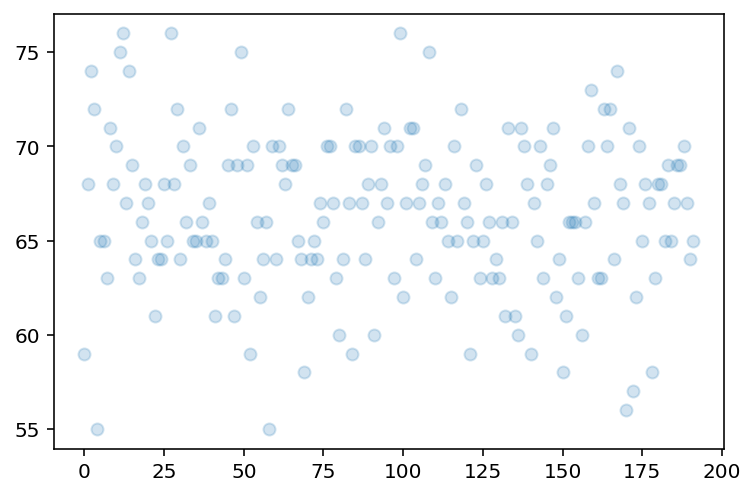

In [81]:
plt.scatter(range(len(result_notes_filtered)), result_notes_filtered, alpha = 0.2); # sorted by time

In [82]:
gan_result

,note,start,duration,diff,local_diff,is_piano,is_organ,is_guitar,is_bass,is_strings,is_ensemble,is_brass,is_reed,is_pipe,is_synth_lead,is_synth_pad
0,67.933556,1.522238,-0.142882,87.605789,0.067351,0.254511,0.015850,0.277370,0.041202,0.141307,0.154762,0.023491,0.068624,-0.004540,0.013457,68.146774
1,72.068787,1.941970,2.573920,48.370358,0.051156,0.212655,0.043395,0.202042,0.100279,0.081828,0.023777,-0.018075,0.010918,0.077031,0.076571,11.039638
2,71.456718,8.027377,1.923625,41.329411,0.133170,0.276330,0.002084,0.103318,0.142051,0.167234,0.116163,0.029831,0.022688,0.007308,0.098176,17.445820
3,70.313210,3.256649,-1.496347,38.318916,0.149814,0.162822,0.022824,0.152231,0.062394,0.039780,0.121291,-0.023803,0.042331,-0.027368,0.086809,9.948693
4,59.128033,1.421284,-0.449774,23.750572,0.073125,0.183424,-0.062736,0.144096,0.117582,0.198141,0.044423,-0.019528,0.057622,0.138106,0.075476,16.360416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,70.897232,21.740976,0.787686,-0.007436,0.099284,0.222680,0.045702,0.311983,0.004545,0.024221,0.119910,-0.005376,0.099161,-0.014435,0.013533,17.785938
188,66.183960,19.491243,0.798326,10.611851,0.025386,0.070316,0.057481,0.213429,-0.009834,0.056623,0.114531,0.041357,0.090094,0.052636,0.008511,13.160013
189,61.638699,26.284065,0.571072,9.083656,0.068981,0.088232,-0.044338,0.361036,0.029478,0.123917,0.078730,0.007080,0.077537,-0.021743,-0.008487,13.454233
190,67.509735,30.962818,0.888313,-2.636603,0.167140,0.150092,0.007931,0.275467,0.059782,0.006734,0.121012,0.020175,0.112918,0.060102,-0.032694,12.213752


In [83]:
from numpy.ma.core import remainder
quantize_measure = 0.125 # 1/16 for 120bpm
scaleA_notes = [0, 2, 4, 5, 7, 9, 11]
finalized_notes = []
def pandasToMIDI(df_input, instrument = 0, filename = "/content/drive/MyDrive/GAN out/gan maybe improve.mid", round_digits = 5, quantize = False, soft_fix_notes = False, transpose_by = 0):
    midi_file = pretty_midi.PrettyMIDI()
    midi_channel = pretty_midi.Instrument(program=instrument)
    min_time = round(min(abs(df_input["start"])), round_digits)
    if(min_time < 0):
        min_time*=-1
    else:
        min_time = 0
    for row in df_input.iterrows():

        # ensure duration is valid
        duration = round(row[1]["duration"], round_digits)
        if(duration < 0):
            duration *=-1
        if(duration > 10):
            duration = 10
        start = -min_time + abs(round(row[1]["start"], round_digits))

        # quantize start times
        if(quantize):
              div = int(start/quantize_measure)
              mod = start/quantize_measure - int(start/quantize_measure)
              start = start - mod * quantize_measure

        # soft-move notes to scale
        if(round(row[1]["note"]) < 1 or round(row[1]["note"]) > 127):
            print("Warning: Integrity issue: %d" %round(row[1]["note"]))
        cur_note = round(row[1]["note"])
        remainder = row[1]["note"] - cur_note
        if(soft_fix_notes):
            # if the current note is not in-scale, but rounded up/down is - convert it. Otherwise - leave note as is.
            if(remainder >= 0.5 and not cur_note%12 in scaleA_notes and (cur_note + 1)%12 in scaleA_notes):
                cur_note = cur_note + 1
            if(remainder < 0.5 and not cur_note%12 in scaleA_notes and (cur_note - 1)%12 in scaleA_notes):
                cur_note = cur_note - 1

        cur_note = cur_note + transpose_by
        if(cur_note >= 0 and cur_note <= 127):
            finalized_notes.append(cur_note)
            note = pretty_midi.Note(velocity=80, pitch=cur_note, start=start, end=start + duration)
            midi_channel.notes.append(note)
            
    midi_file.instruments.append(midi_channel)
    midi_file.write(filename)
    print("File created: %s" %filename)
    return finalized_notes

In [84]:
from random import randrange
start_time_filtered_df = gan_result[gan_result["start"] >= 0]
duration_filtered_df = start_time_filtered_df[start_time_filtered_df["duration"] > 0]
print("Percentage of valid notes: %f" %(len(duration_filtered_df)/comp_length))
written_notes = pandasToMIDI(duration_filtered_df, round_digits=3, quantize = True, soft_fix_notes = True, transpose_by= randrange(-6,5))

Percentage of valid notes: 0.906250
File created: /content/drive/MyDrive/GAN out/gan maybe improve.mid


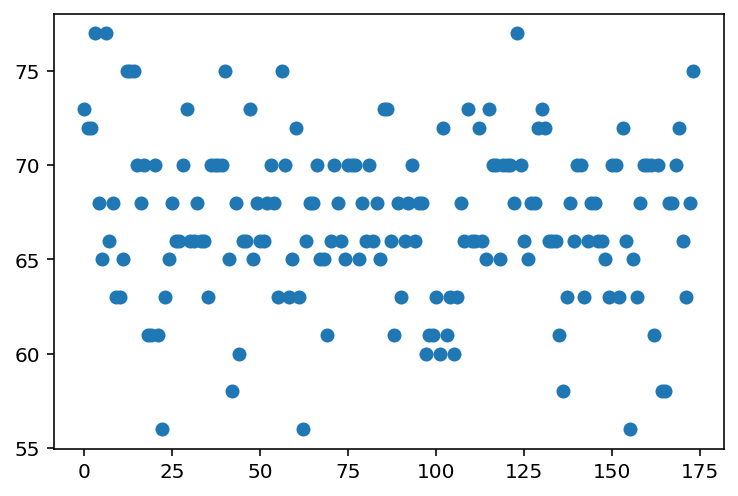

In [85]:
plt.scatter(range(len(written_notes)), written_notes);

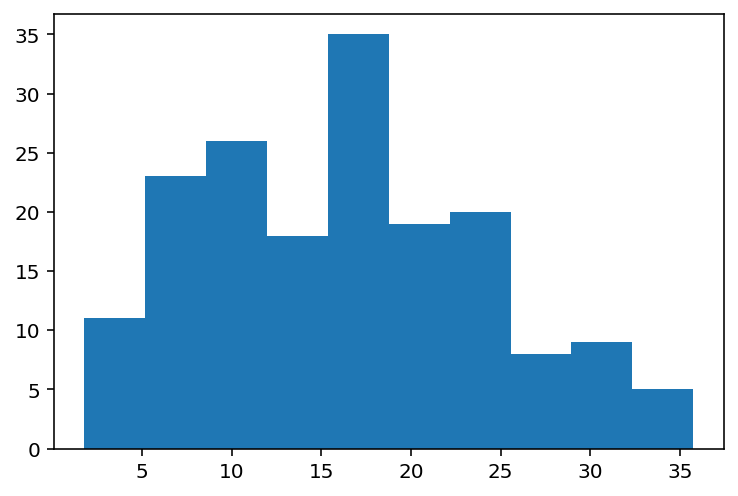

In [86]:
plt.hist(duration_filtered_df["start"]);

In [87]:
duration_filtered_df

,note,start,duration,diff,local_diff,is_piano,is_organ,is_guitar,is_bass,is_strings,is_ensemble,is_brass,is_reed,is_pipe,is_synth_lead,is_synth_pad
1,72.068787,1.941970,2.573920,48.370358,0.051156,0.212655,0.043395,0.202042,0.100279,0.081828,0.023777,-0.018075,0.010918,0.077031,0.076571,11.039638
2,71.456718,8.027377,1.923625,41.329411,0.133170,0.276330,0.002084,0.103318,0.142051,0.167234,0.116163,0.029831,0.022688,0.007308,0.098176,17.445820
5,70.777649,3.166111,1.219841,30.638205,0.088909,0.264396,-0.037759,0.212885,0.073383,0.058602,0.104813,0.016978,0.117675,0.010744,0.138756,10.442491
6,75.721313,4.406404,2.433693,20.308794,0.044940,0.225711,0.044148,0.211432,0.091473,0.161247,0.134628,0.048329,0.113505,-0.006454,0.084846,10.574366
7,67.674988,5.518581,2.208399,19.088259,0.061811,0.254311,0.084295,0.230447,0.017378,0.133149,0.143206,-0.021871,0.111352,0.014427,0.067797,7.541881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,70.897232,21.740976,0.787686,-0.007436,0.099284,0.222680,0.045702,0.311983,0.004545,0.024221,0.119910,-0.005376,0.099161,-0.014435,0.013533,17.785938
188,66.183960,19.491243,0.798326,10.611851,0.025386,0.070316,0.057481,0.213429,-0.009834,0.056623,0.114531,0.041357,0.090094,0.052636,0.008511,13.160013
189,61.638699,26.284065,0.571072,9.083656,0.068981,0.088232,-0.044338,0.361036,0.029478,0.123917,0.078730,0.007080,0.077537,-0.021743,-0.008487,13.454233
190,67.509735,30.962818,0.888313,-2.636603,0.167140,0.150092,0.007931,0.275467,0.059782,0.006734,0.121012,0.020175,0.112918,0.060102,-0.032694,12.213752


### The model is successful, save it on disk for later use.

In [88]:
save_model = True
if(save_model):
    from joblib import dump, load

    generator = generator.to("cpu")
    discriminator = discriminator.to("cpu")

    generator.eval()
    discriminator.eval()

    torch.save(generator, "/content/drive/MyDrive/Data Science project/GAN_generator_5.dat")
    torch.save(discriminator, "/content/drive/MyDrive/Data Science project/GAN_discriminator_5.dat")
    dump(scaler, "/content/drive/MyDrive/Data Science project/GAN_scaler_5.dat") 

In [89]:
if(save_model):
    g = torch.load("/content/drive/MyDrive/Data Science project/GAN_generator_5.dat")
    print(g)
    d = torch.load("/content/drive/MyDrive/Data Science project/GAN_discriminator_5.dat")
    print(d)
    s = load("/content/drive/MyDrive/Data Science project/GAN_scaler_5.dat")
    print(s)

Generator(
  (fc1): Sequential(
    (0): Linear(in_features=192, out_features=384, bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=384, out_features=768, bias=False)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=768, out_features=960, bias=False)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=960, out_features=1152, bias=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=1152, out_features=1344, bias=False)
    (9): LeakyReLU(negative_slope=0.2)
    (10): Linear(in_features=1344, out_features=1536, bias=False)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Linear(in_features=1536, out_features=3072, bias=False)
  )
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1d(16, 32, kernel_size=(32,), stride=(1,), padding=same)
  (fc2): Sequential(
    (0): Linear(in_features=3072, out_features=1536, bias=False)
    (1): LeakyReLU(negative_slop

In [90]:
generator.to(device)
discriminator.to(device)

Discriminator(
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1d(16, 32, kernel_size=(32,), stride=(1,), padding=same)
  (mp1): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
  (fc1): Sequential(
    (0): Linear(in_features=6144, out_features=6144, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Conv1d(32, 64, kernel_size=(32,), stride=(1,), padding=same)
  (mp2): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
  (fc2): Sequential(
    (0): Linear(in_features=12288, out_features=12288, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Conv1d(64, 256, kernel_size=(8,), stride=(1,), padding=same)
  (mp3): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
  (fc3): Sequential(
    (0): Linear(in_features=3072, out_features=3072, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): LeakyReLU(negative_slope=0.2)
 